# Part 2: Generalization across subjects

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data pre-processing
from scipy.io import loadmat
from scipy.ndimage import convolve1d

# Machine Learning
from sklearn.svm import SVC 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

# Other
import random
import sys
import sys
sys.stdout.flush()


## Task 1: Preprocessing

### Set features

In [5]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis = 0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)
# Variance
var = lambda x: np.var(x, axis=0)

### Build dataset function

In [6]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()

            # Skip empty trials
            if not np.any(selected_tsteps):
                continue
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels


### Function for removing trials
Removes bad trials based on the total variance of the trial.

In [7]:
def remove_bad_trials(emg_data, stimulus, repetition, threshold = 0.005) :
    """ Removes trials where the signal variance is below a threshold"""

    unique_trials = np.unique(np.column_stack((stimulus, repetition)), axis=0)
    good_trial_indices = []
    bad_trial_indices = []

    for trial_id, trial in enumerate(unique_trials):
        trial_mask = np.logical_and(stimulus == trial[0], repetition == trial[1]).squeeze()
        # print(f"trialmask: {trial_mask}")
        trial_data = emg_data[trial_mask]
        # print(f"emg data shape {emg_data.shape}")
        # print(f"trial_data {trial_data.shape}")

        #Check variance across all channels
        if np.var(trial_data) >= threshold:
            good_trial_indices.append(trial_mask)
        else:
            bad_trial_indices.append((trial[0], trial[1]))
    
    # good_mask = np.isin(np.column_stack((stimulus, repetition)), good_trial_indices, assume_unique=True)
    good_mask = np.any(np.column_stack(good_trial_indices), axis=1)

    clean_emg = emg_data[good_mask.squeeze()]
    clean_stimulus = stimulus[good_mask.squeeze()]
    clean_repetition = repetition[good_mask.squeeze()]

    return clean_emg, clean_stimulus, clean_repetition, bad_trial_indices

### Remove bad trials for all subjects and create a dataset that combines all subjects

In [8]:
# Process all subjects and combine datasets
data_folder = "data/part_2"
subject_files = [f"{data_folder}/S{i}_A1_E1.mat" for i in range(1, 28)]

# Selecting the features of interest
features_names = ['mav', 'std', 'maxav', 'rms', 'wl', 'ssc', 'var']
features = [mav, std, maxav, rms, wl, ssc, var]

all_datasets = []
all_labels = []
all_subject_ids = []
processed_subjects = [] # List to store datasets for each subject


for subject_id, file_path in enumerate(subject_files, start=1):
    data = loadmat(file_path)
    emg = data["emg"]
    stimulus = data["restimulus"]
    repitition = data["rerepetition"]


    clean_emg, clean_stimulus, clean_repetition, bad_trial_indices = remove_bad_trials(emg, stimulus, repitition, threshold=0.001)
    # clean_emg, clean_stimulus, clean_repetition, bad_trial_indices = emg, stimulus, repitition, [0]
    

    # Just for printing
    bad_trial_indices_cleaned = [(int(stim), int(rep)) for stim, rep in bad_trial_indices]
    print(f"Bad trials: {bad_trial_indices_cleaned}")
    print(f"Emg new shape: {clean_emg.shape}")

    subject_dataset, subject_labels = build_dataset_from_ninapro(clean_emg, clean_stimulus, clean_repetition, features=features)
    mask = subject_labels != 0
    subject_dataset = subject_dataset[mask]
    subject_labels = subject_labels[mask]

    print(f"Subject dataset shape: {subject_dataset.shape}")

    # Save processed dataset and labels 
    processed_subjects.append({
        "id": subject_id,
        "dataset": subject_dataset,
        "labels": subject_labels,
        "stimulus": clean_stimulus,
        "repetition": clean_repetition,
    })

    # Append to combined dataset
    all_datasets.append(subject_dataset)
    all_labels.append(subject_labels)
    all_subject_ids.extend([subject_id] * len(subject_labels))

# Combine all subjects into unified arrays
X_all = np.vstack(all_datasets)
y_all = np.hstack(all_labels)
subject_ids = np.array(all_subject_ids)

print(f"Combined dataset shape: {X_all.shape}")
print(f"Labels shape: {y_all.shape}")
print("Unique labels in y_all:", np.unique(y_all))
print(f"Subject IDs shape: {subject_ids.shape}")
    

Bad trials: [(10, 1), (12, 5), (12, 6), (12, 8)]
Emg new shape: (99248, 10)
Subject dataset shape: (117, 70)
Bad trials: []
Emg new shape: (100686, 10)
Subject dataset shape: (120, 70)
Bad trials: []
Emg new shape: (100720, 10)
Subject dataset shape: (120, 70)
Bad trials: [(12, 4), (12, 5), (12, 6), (12, 7), (12, 9)]
Emg new shape: (98603, 10)
Subject dataset shape: (118, 70)
Bad trials: []
Emg new shape: (100894, 10)
Subject dataset shape: (120, 70)
Bad trials: []
Emg new shape: (101083, 10)
Subject dataset shape: (120, 70)
Bad trials: []
Emg new shape: (100817, 10)
Subject dataset shape: (120, 70)
Bad trials: []
Emg new shape: (100854, 10)
Subject dataset shape: (120, 70)
Bad trials: []
Emg new shape: (100925, 10)
Subject dataset shape: (120, 70)
Bad trials: []
Emg new shape: (100778, 10)
Subject dataset shape: (120, 70)
Bad trials: []
Emg new shape: (100899, 10)
Subject dataset shape: (120, 70)
Bad trials: []
Emg new shape: (100920, 10)
Subject dataset shape: (120, 70)
Bad trials: [

### Plot some trials

Code for plotting a couple of random removed trials and good trials, to validate that the removed ones should indeed be removed.

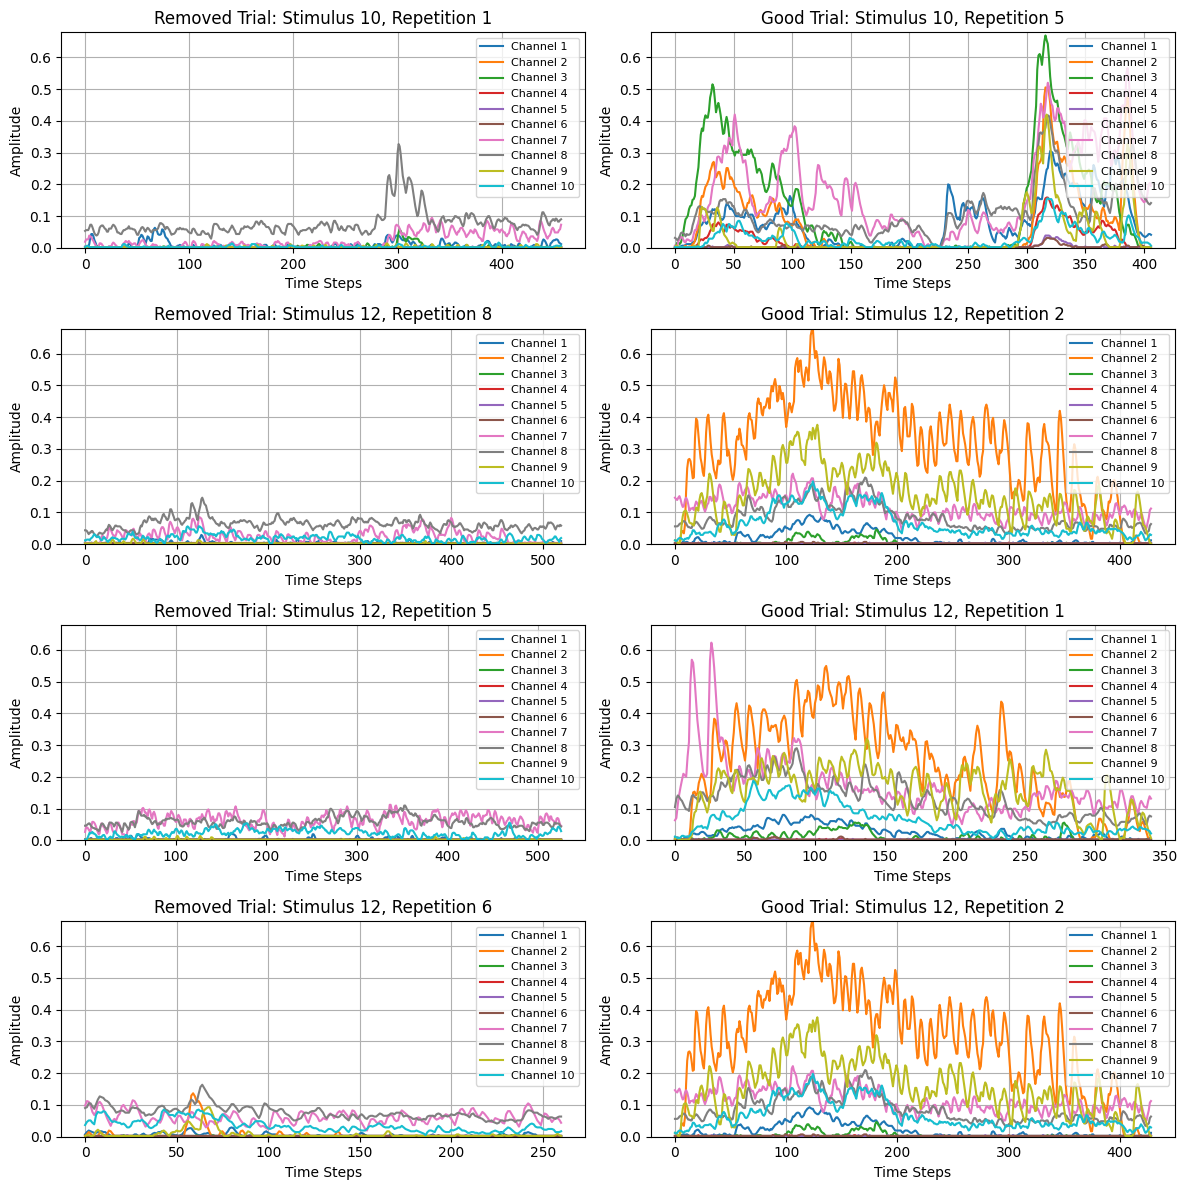

In [13]:
def plot_removed_and_good_trials_same_stimulus(emg, stimulus, repetition, bad_trials, num_trials=3):
    # Randomly select bad trials
    selected_bad_trials = random.sample(bad_trials, min(num_trials, len(bad_trials)))
    
    # Get all trials (stimulus, repetition) pairs
    all_trials = np.unique(np.column_stack((stimulus, repetition)), axis=0)
    good_trials = [trial for trial in all_trials if tuple(trial) not in bad_trials]

    # Filter good trials to match the stimulus IDs of the selected bad trials
    matching_good_trials = []
    for bad_stimulus_id, _ in selected_bad_trials:
        matching_good = [trial for trial in good_trials if trial[0] == bad_stimulus_id]
        if matching_good:
            matching_good_trials.append(random.choice(matching_good))

    # Ensure equal num of pairs
    num_pairs = min(len(selected_bad_trials), len(matching_good_trials))
    selected_bad_trials = selected_bad_trials[:num_pairs]
    matching_good_trials = matching_good_trials[:num_pairs]

    # Calculate global min and max amplitude across selected trials
    global_min, global_max = float('inf'), float('-inf')
    for trial_list in [selected_bad_trials, matching_good_trials]:
        for stimulus_id, repetition_id in trial_list:
            trial_mask = np.logical_and(stimulus == stimulus_id, repetition == repetition_id).squeeze()
            trial_emg = emg[trial_mask]
            global_min = min(global_min, trial_emg.min())
            global_max = max(global_max, trial_emg.max())

    # Create subplots for each pair of removed and good trials
    fig, axs = plt.subplots(num_pairs, 2, figsize=(12, 3 * num_pairs))

    if num_pairs == 1: 
        axs = [axs]

    for ax_row, (bad_trial, good_trial) in zip(axs, zip(selected_bad_trials, matching_good_trials)):
        # Plot removed trial (left)
        bad_stimulus_id, bad_repetition_id = bad_trial
        bad_mask = np.logical_and(stimulus == bad_stimulus_id, repetition == bad_repetition_id).squeeze()
        bad_emg = emg[bad_mask]

        for channel in range(bad_emg.shape[1]):
            ax_row[0].plot(bad_emg[:, channel], label=f"Channel {channel + 1}")

        ax_row[0].set_title(f"Removed Trial: Stimulus {bad_stimulus_id}, Repetition {bad_repetition_id}")
        ax_row[0].set_xlabel("Time Steps")
        ax_row[0].set_ylabel("Amplitude")
        ax_row[0].legend(loc="upper right", fontsize=8)
        ax_row[0].grid()
        ax_row[0].set_ylim(global_min, global_max)  

        # Plot good trial (right)
        good_stimulus_id, good_repetition_id = good_trial
        good_mask = np.logical_and(stimulus == good_stimulus_id, repetition == good_repetition_id).squeeze()
        good_emg = emg[good_mask]

        for channel in range(good_emg.shape[1]):
            ax_row[1].plot(good_emg[:, channel], label=f"Channel {channel + 1}")

        ax_row[1].set_title(f"Good Trial: Stimulus {good_stimulus_id}, Repetition {good_repetition_id}")
        ax_row[1].set_xlabel("Time Steps")
        ax_row[1].set_ylabel("Amplitude")
        ax_row[1].legend(loc="upper right", fontsize=8)
        ax_row[1].grid()
        ax_row[1].set_ylim(global_min, global_max)  

    plt.tight_layout()
    plt.show()


# Plot removed and good trials for a specific subject 
subject_id_to_plot = 1
subject_data = loadmat(subject_files[subject_id_to_plot - 1])
emg = subject_data["emg"]
stimulus = subject_data["restimulus"]
repetition = subject_data["rerepetition"]

# Filter bad trials for this subject
_, _, _, bad_trials = remove_bad_trials(emg, stimulus, repetition, threshold=0.001)

plot_removed_and_good_trials_same_stimulus(emg, stimulus, repetition, bad_trials, num_trials=5)


After having run this quite a few times it is clear that there is a very large difference in the typical good data and removed data. Looking at the y-axis it is clear that the trials that are being removed are clearly not exibiting a high amplitude of signal and are most likely just due to noise. 

## Task 2: Examining features across subjects


In [14]:
subject_feature_movement = []

for subject_data in processed_subjects:
    # Use the precomputed dataset
    dataset = subject_data["dataset"]
    stimulus = subject_data["stimulus"]
    repetition = subject_data["repetition"]

    # Calculate averages for each stimulus
    n_stimuli = len(np.unique(stimulus)) - 1  # -1 to exclude resting condition
    n_repetitions = len(np.unique(repetition)) - 1  # -1 to exclude non-repetitions
    n_channels = dataset.shape[1] // len(features)  
    subject_movement_features = []

    for i in range(len(features)):
        feature_stimuli = np.zeros((n_stimuli, n_channels))  # Average features for each stimulus
        feature_idx = i * n_channels + np.arange(n_channels)
        for j in range(n_stimuli-1):
            idx_repetitions = np.arange(j * n_repetitions, (j + 1) * n_repetitions)
            feature_stimuli[j, :] = np.mean(dataset[idx_repetitions[:, None], feature_idx], axis=0)
        subject_movement_features.append(feature_stimuli)

    subject_feature_movement.append(subject_movement_features)


In [15]:
def normalize_features(subject_feature_movement):
    normalized_subjects = []
    for subject_features in subject_feature_movement:
        normalized_features = []
        for feature in subject_features:
            # Normalize the feature across all movements and channels
            min_val = np.min(feature)
            max_val = np.max(feature)
            normalized = (feature - min_val) / (max_val - min_val) if max_val > min_val else feature
            normalized_features.append(normalized)
        normalized_subjects.append(normalized_features)
    return normalized_subjects


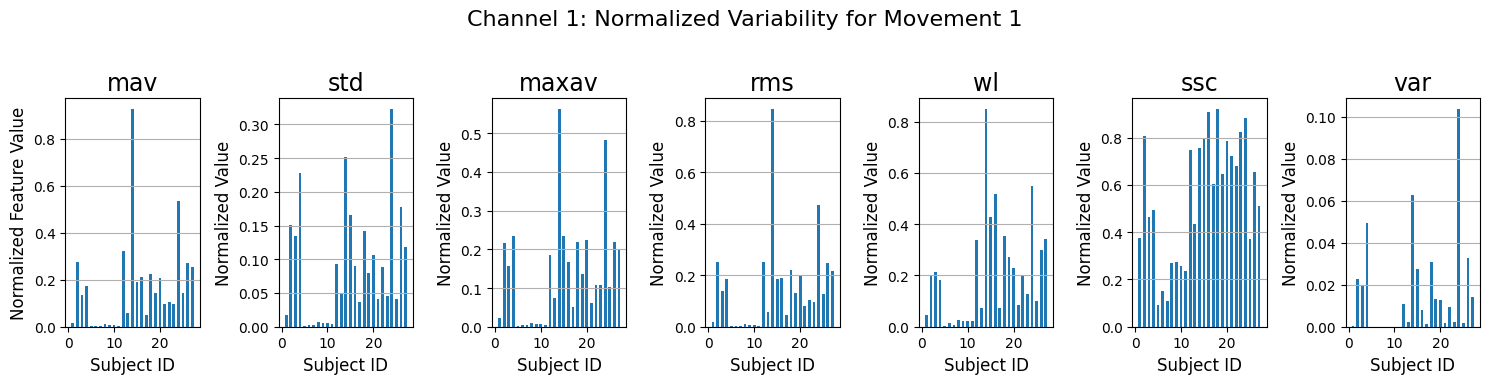

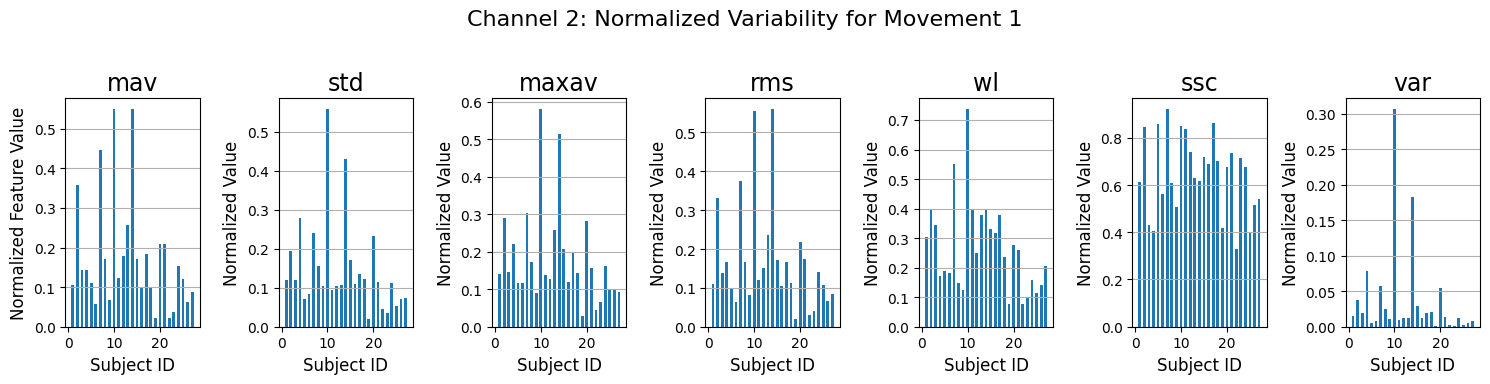

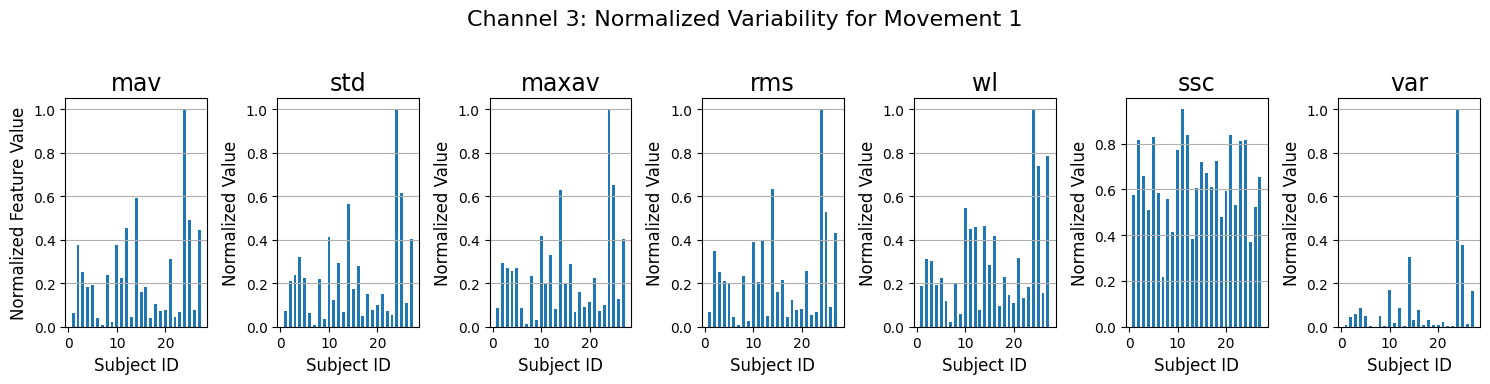

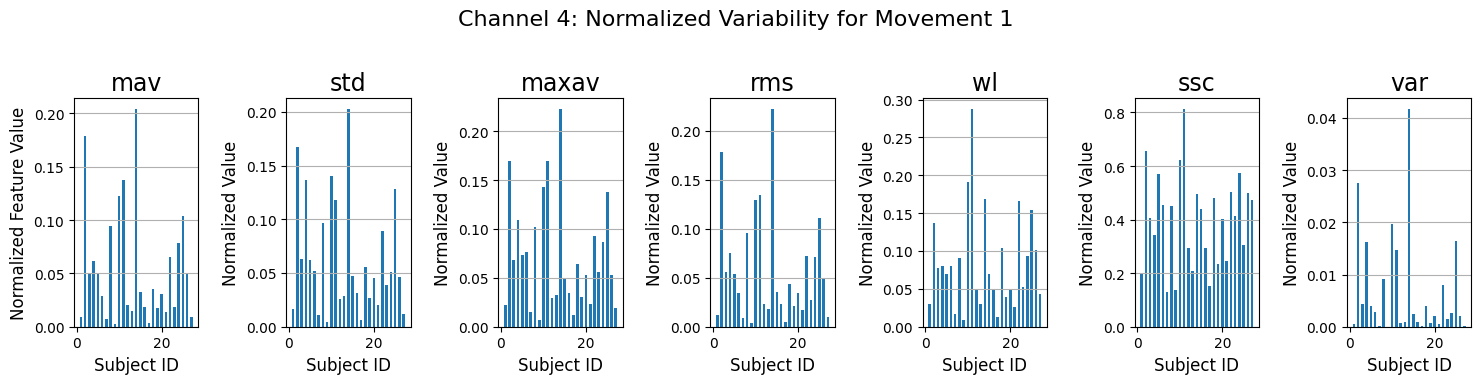

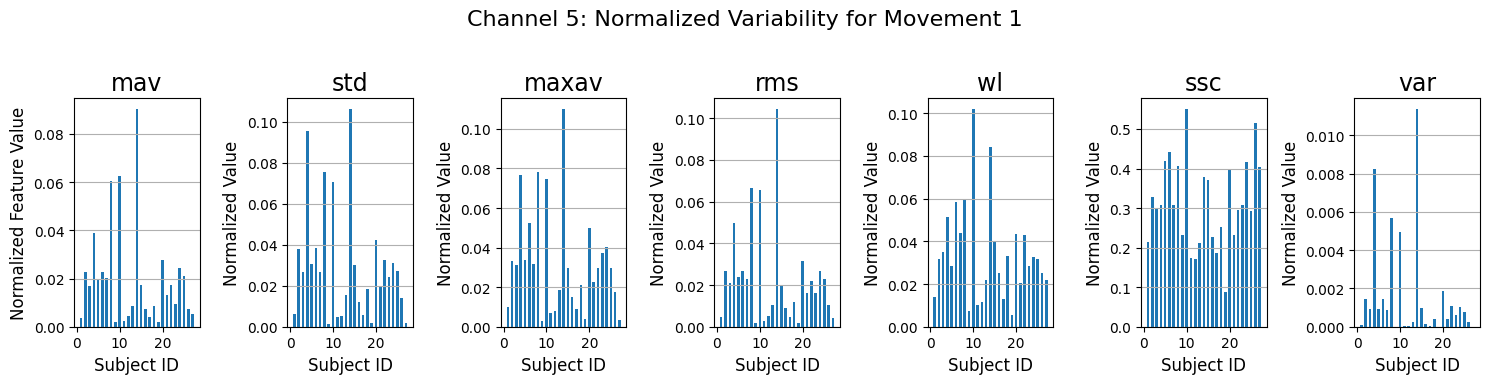

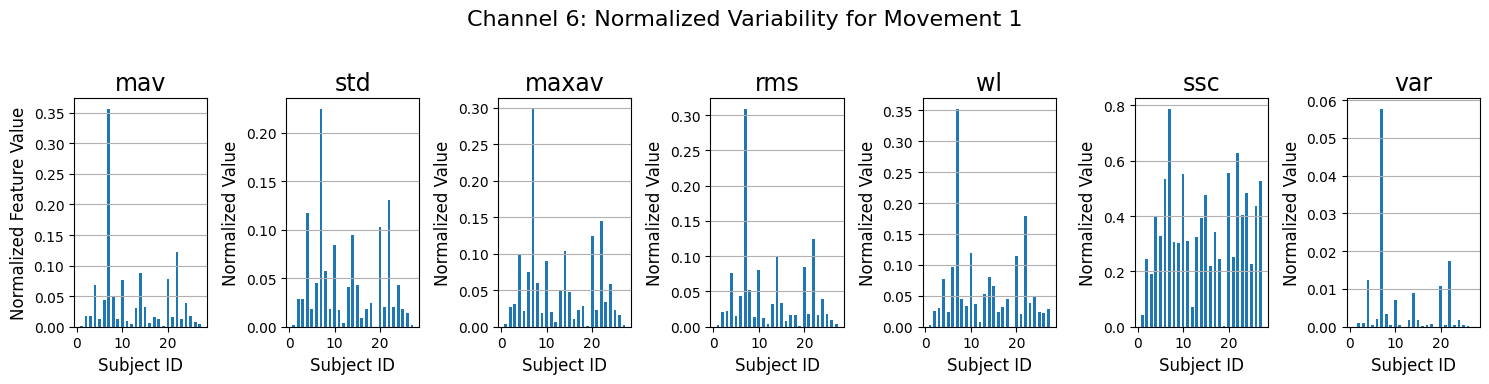

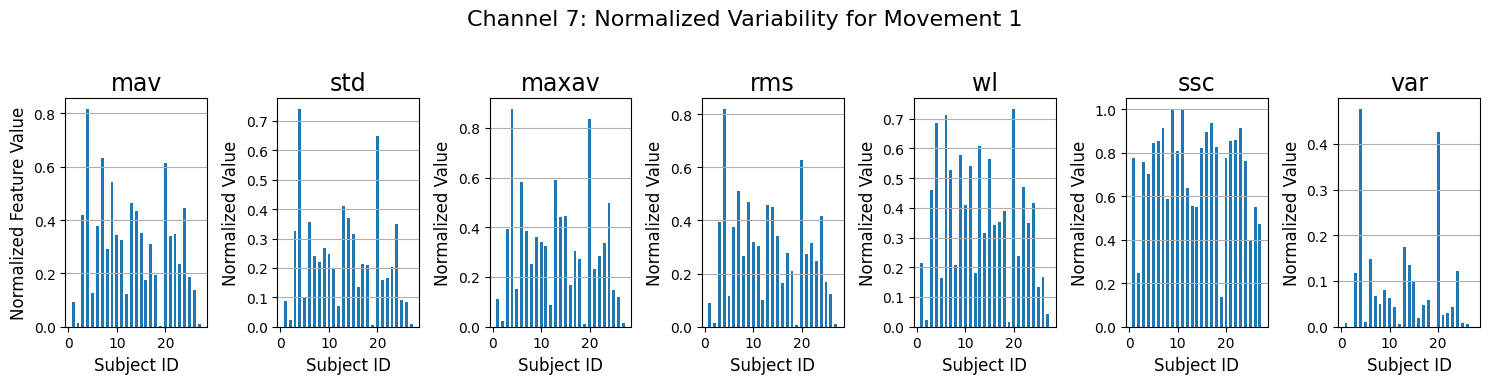

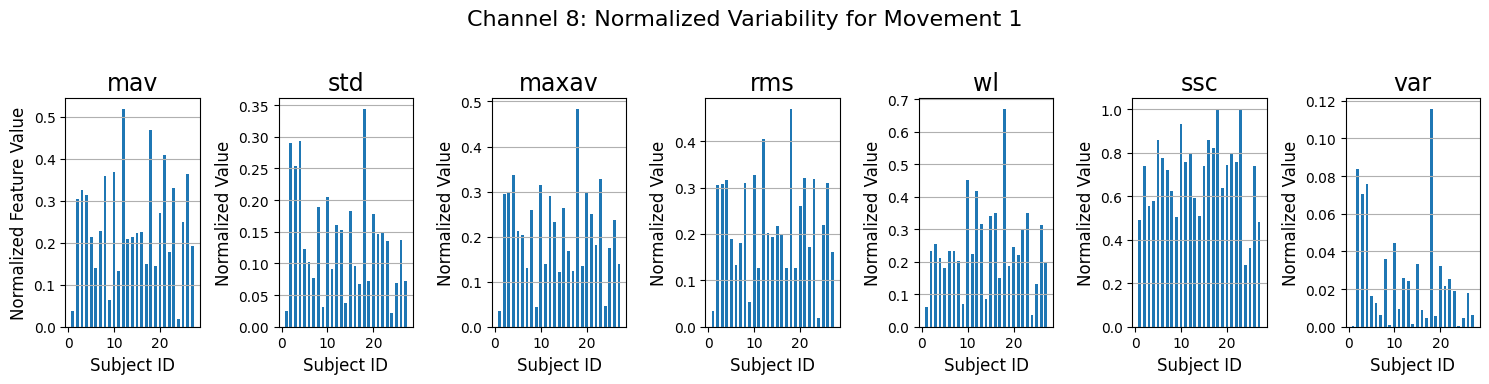

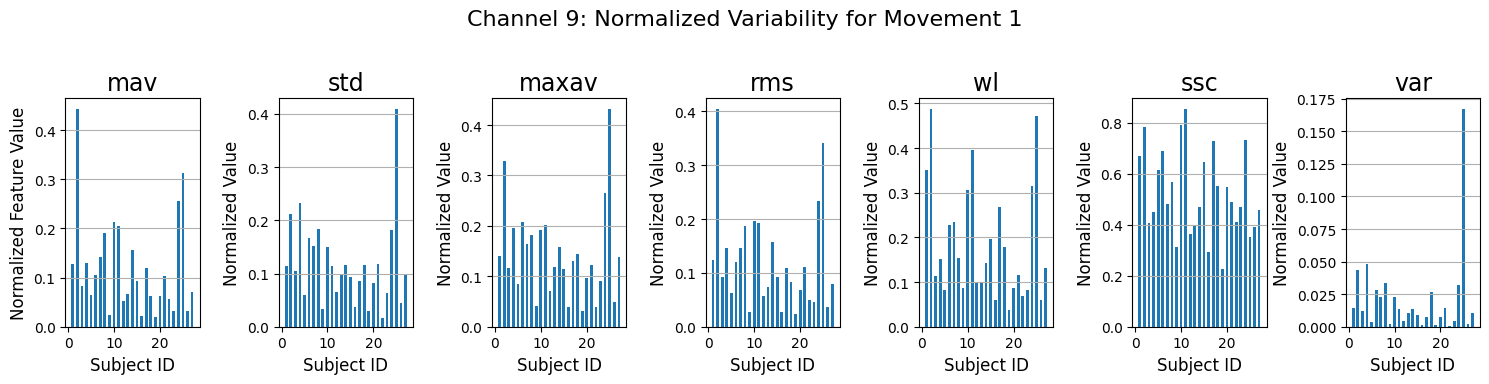

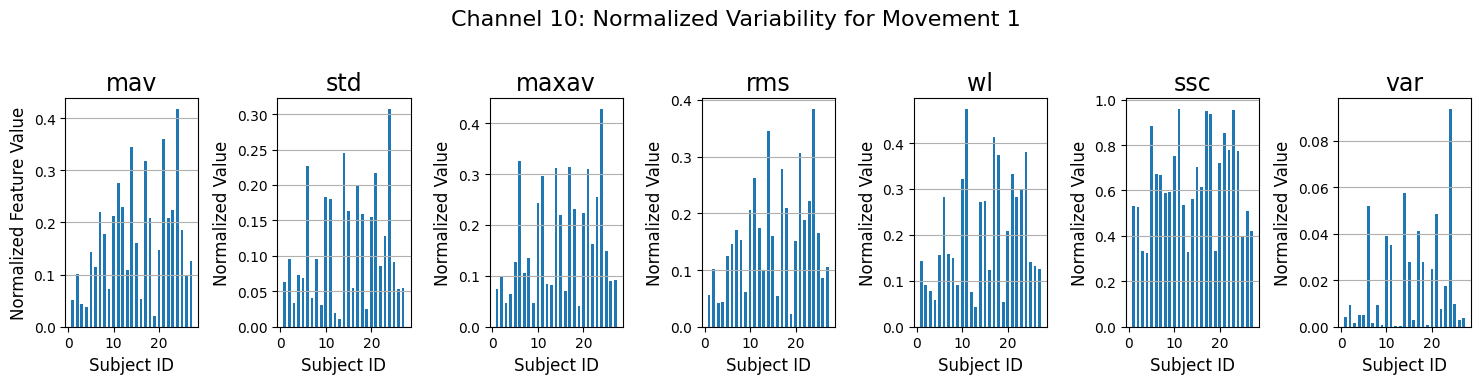

In [ ]:
def plot_avg_per_channel_for_movement(subject_feature_movement, features_names, chosen_movement, n_channels):
    # Normalize the features
    normalized_subjects = normalize_features(subject_feature_movement)
    
    for channel in range(n_channels):
        # Create a figure for the channel
        fig, axs = plt.subplots(1, len(features_names), figsize=(15, 4), sharex=False) 
        fig.suptitle(f"Channel {channel + 1}: Normalized Variability for Movement {chosen_movement + 1}", fontsize=16)

        # Loop through features
        for i, feature_name in enumerate(features_names):
            num_subjects = len(normalized_subjects)
            bar_width = 0.6 

            subject_values = [
                normalized_subjects[subject_id][i][chosen_movement, channel] for subject_id in range(num_subjects)
            ]

            # Bar positions
            x_axis = np.arange(1, num_subjects + 1)  # Subject IDs 
            axs[i].bar(
                x_axis,
                subject_values,  # Normalized feature values for chosen movement, feature, and channel
                width=bar_width,
                label="Subjects"
            )

            axs[i].set_title(f"{feature_name}", fontsize=17)
            axs[i].set_ylabel("Normalized Value", fontsize=12)
            axs[i].set_xlabel("Subject ID", fontsize=12) 
            axs[i].grid(axis='y')

        axs[0].set_ylabel("Normalized Feature Value", fontsize=12)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
        plt.show()


# Specify the movement 
chosen_movement = 0  # Movement index to visualize

plot_avg_per_channel_for_movement(subject_feature_movement, features_names, chosen_movement, n_channels)


## Task 3: Training Classifier

### Splitting into train and test
Since the dataset is highly unbalanced a special sort of splitting of the data or training of the model is necessary. First of all it is important to startify the splitting, meaning that the train and test splits have similar class distributions. Then there are other possible measures such as using a stratifiedKFold for Cross-Validation, this ensures that each fold has a similar class distribution, which allows us to evalueate model on multiple train-test splits, which would bake it robust to bias from a single split. This could then be combined with oversampling the minority classes (Synthetic Minority Oversampling Technique). This generates synthetic samples for the minority class in the training data. Another option instead of SMOT would be to adjust the model's loss function to penalize misclassifications of the minority class more heavily. This is very simple when using SVM so here we are implementing StratifiedKFold cross-validation and balancing class weights.

#### Oversampling minority classes

In [17]:

# Leave-One-Subject-Out Split
test_subject = 5  # Specify the subject to leave out for testing
train_mask = subject_ids != test_subject
test_mask = subject_ids == test_subject

# Splitting the data
X_train, X_test = X_all[train_mask], X_all[test_mask]
y_train, y_test = y_all[train_mask], y_all[test_mask]

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the resampled data
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train_resampled)
X_test_z = scaler.transform(X_test)

print(f"Shapes after SMOTE = X_train: {X_train_z.shape} | X_test: {X_test_z.shape}")

Shapes after SMOTE = X_train: (3120, 70) | X_test: (120, 70)


### Finding the best parameters

In [18]:

svc = SVC( random_state=42)

param_grid = {
    'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],  # Focus on commonly used kernels
    'C': [ 0.1, 1, 10, 100],
    'gamma': [1e-3, 1e-2, 0.1],
    'degree': [2, 3, 4] 
}

# StratifiedKFold cross-validator
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Optimized GridSearchCV with parallel processing
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='f1_macro',
    refit=True,
    cv=skf,
    verbose=3,
    n_jobs=-1  # Use all available processors
)

# Fit the grid search to the training data
grid_search.fit(X_train_z, y_train_resampled)
sys.stdout.flush()
print(f"Best hyperparameters: {grid_search.best_params_}")

# Get the best model
best_model = grid_search.best_estimator_


Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best hyperparameters: {'C': 100, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


### Train SVM


Training the best model:

*** Results ***
Accuracy score: 0.3333
F1-score: 0.2664


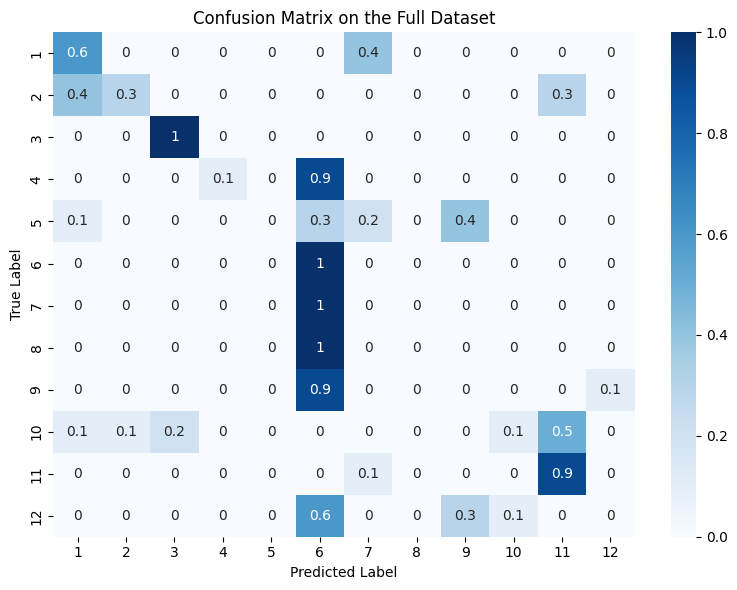

In [42]:

model = SVC(kernel='rbf', C=10, gamma=0.1, class_weight='balanced', random_state=42)

# Train the best model on the entire training set
print("\nTraining the best model:")
best_model.fit(X_train_z, y_train_resampled)
#model.fit(X_train_z, y_train_resampled)

# Predict on the test set
y_pred = best_model.predict(X_test_z)

# Calculate metrics
accuracy_test = accuracy_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred, average='macro')
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Print results
print("\n*** Results ***")
print(f"Accuracy score: {round(accuracy_test, 4)}")
print(f"F1-score: {round(f1_score_test, 4)}")

# Plot confusion matrix using a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confmat, annot=True, cmap="Blues", ax=ax, cbar=True)

plt.title("Confusion Matrix on the Full Dataset")
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")

# Set the x, y ticks and labels
n_classes = confmat.shape[0]  # Number of classes
ax.set_xticks(0.5 + np.arange(n_classes))
ax.set_yticks(0.5 + np.arange(n_classes))
ax.set_xticklabels(np.arange(1, n_classes + 1))
ax.set_yticklabels(np.arange(1, n_classes + 1))

plt.tight_layout()
plt.show()


#### Trying to improve score by adding pipeline

In [31]:
# Add polynomial features
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', class_weight='balanced', random_state=42))
])

pipeline.fit(X_train_z, y_train)
y_pred = pipeline.predict(X_test_z)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

Accuracy: 0.2083, F1-Score: 0.1640


## Task 4: Cross-validation

In [34]:


# Assume X_all, y_all, and subject_ids are already defined

# Initialize variables to store results
results = []

# Get unique subject IDs
unique_subjects = np.unique(subject_ids)


# Iterate over each subject as the test set
for test_subject in unique_subjects:
    print(f"Testing on subject {test_subject}...")

    # Split data
    train_mask = subject_ids != test_subject  # All subjects except the test subject
    test_mask = subject_ids == test_subject  # Only the test subject

    X_train, X_test = X_all[train_mask], X_all[test_mask]
    y_train, y_test = y_all[train_mask], y_all[test_mask]

    # Standardize the data
    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)

    # Train the SVM model
    model = SVC(kernel='rbf', C=10, gamma=0.1, class_weight='balanced', random_state=42)
    model.fit(X_train_z, y_train)

    # Test the model
    y_pred = model.predict(X_test_z)

    # Evaluate performance
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    confmat = confusion_matrix(y_test, y_pred, normalize="true")

    print(f"Subject {test_subject}: Accuracy = {acc:.4f}, F1-score = {f1:.4f}")
    results.append({'subject': test_subject, 'accuracy': acc, 'f1': f1, 'confmat': confmat})

# Summarize performance across all subjects
average_accuracy = np.mean([res['accuracy'] for res in results])
average_f1 = np.mean([res['f1'] for res in results])
print("\n*** Summary of Leave-One-Subject-Out Cross-Validation ***")
print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average F1-Score: {average_f1:.4f}")

Testing on subject 1...
Subject 1: Accuracy = 0.3590, F1-score = 0.3173
Testing on subject 2...
Subject 2: Accuracy = 0.1000, F1-score = 0.0541
Testing on subject 3...
Subject 3: Accuracy = 0.3333, F1-score = 0.3190
Testing on subject 4...
Subject 4: Accuracy = 0.3136, F1-score = 0.2736
Testing on subject 5...
Subject 5: Accuracy = 0.3333, F1-score = 0.2664
Testing on subject 6...
Subject 6: Accuracy = 0.2167, F1-score = 0.2095
Testing on subject 7...
Subject 7: Accuracy = 0.1333, F1-score = 0.1042
Testing on subject 8...
Subject 8: Accuracy = 0.2833, F1-score = 0.2670
Testing on subject 9...
Subject 9: Accuracy = 0.1917, F1-score = 0.1254
Testing on subject 10...
Subject 10: Accuracy = 0.2667, F1-score = 0.2579
Testing on subject 11...
Subject 11: Accuracy = 0.2500, F1-score = 0.1493
Testing on subject 12...
Subject 12: Accuracy = 0.3250, F1-score = 0.2382
Testing on subject 13...
Subject 13: Accuracy = 0.2833, F1-score = 0.2758
Testing on subject 14...
Subject 14: Accuracy = 0.3417, 

### Plot confusion matrix for a single subject

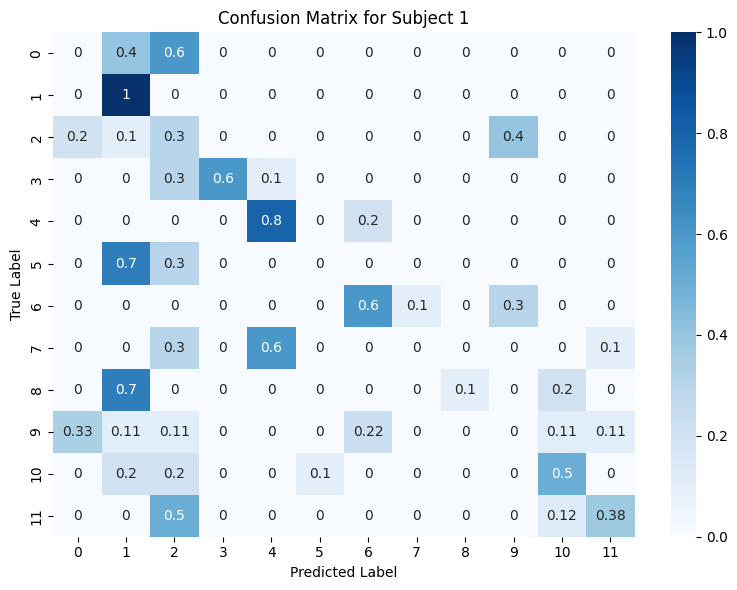

In [46]:
# Plot confusion matrix for one subject 
example_subject = 1
example_result = next(res for res in results if res['subject'] == example_subject)
confmat = example_result['confmat']

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confmat, annot=True, cmap="Blues", ax=ax, cbar=True)
plt.title(f"Confusion Matrix for Subject {example_subject}")
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()
plt.show()

### Plot f1 and accuracy scores

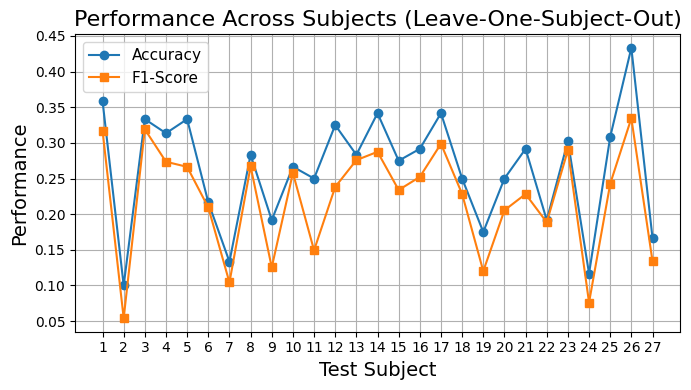

In [50]:
# Plot accuracy and F1-score for each subject
subjects = [res['subject'] for res in results]
accuracies = [res['accuracy'] for res in results]
f1_scores = [res['f1'] for res in results]

plt.figure(figsize=(7, 4))
plt.plot(subjects, accuracies, marker='o', label='Accuracy')
plt.plot(subjects, f1_scores, marker='s', label='F1-Score')
plt.title("Performance Across Subjects (Leave-One-Subject-Out)",fontsize=16)
plt.xlabel("Test Subject",fontsize=14)
plt.ylabel("Performance",fontsize=14)
plt.xticks(subjects)  # Ensure x-axis corresponds to subject IDs
plt.legend(fontsize=11)
plt.grid()
plt.tight_layout()
plt.show()

## Task 5: Varying num of subjects in training set

Training with 1 subjects: Accuracy = 0.0833, F1-score = 0.0128
Training with 2 subjects: Accuracy = 0.1000, F1-score = 0.0370
Training with 3 subjects: Accuracy = 0.1083, F1-score = 0.0562
Training with 4 subjects: Accuracy = 0.1333, F1-score = 0.0815
Training with 5 subjects: Accuracy = 0.1917, F1-score = 0.1305
Training with 6 subjects: Accuracy = 0.1917, F1-score = 0.1815
Training with 7 subjects: Accuracy = 0.1583, F1-score = 0.1374
Training with 8 subjects: Accuracy = 0.1917, F1-score = 0.1467
Training with 9 subjects: Accuracy = 0.1833, F1-score = 0.1172
Training with 10 subjects: Accuracy = 0.1583, F1-score = 0.1111
Training with 11 subjects: Accuracy = 0.1917, F1-score = 0.1360
Training with 12 subjects: Accuracy = 0.2417, F1-score = 0.1839
Training with 13 subjects: Accuracy = 0.1750, F1-score = 0.1478
Training with 14 subjects: Accuracy = 0.2500, F1-score = 0.2046
Training with 15 subjects: Accuracy = 0.2333, F1-score = 0.1906
Training with 16 subjects: Accuracy = 0.2583, F1-

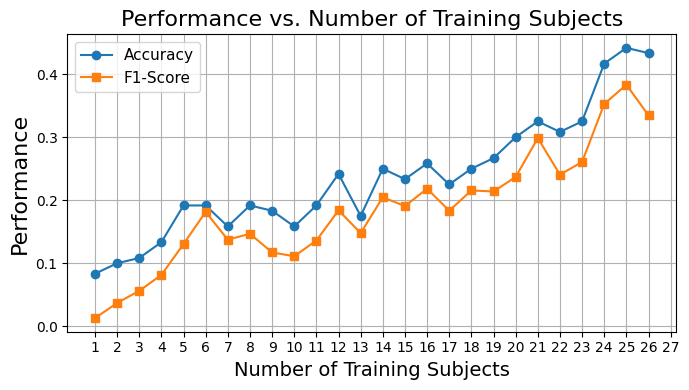

In [51]:
# Define the test subject (e.g., subject 27)
test_subject = 26

# Mask for the test subject
test_mask = subject_ids == test_subject
X_test, y_test = X_all[test_mask], y_all[test_mask]

# Initialize lists to store results
training_sizes = []
accuracies = []
f1_scores = []

# Iterate through subsets of training subjects
unique_subjects = np.unique(subject_ids)
training_subjects = unique_subjects[unique_subjects != test_subject]  # Exclude test subject

for i in range(1, len(training_subjects) + 1):
    # Use the first `i` subjects for training
    current_train_subjects = training_subjects[:i]
    train_mask = np.isin(subject_ids, current_train_subjects)
    X_train, y_train = X_all[train_mask], y_all[train_mask]

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Standardize the data
    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train_resampled)
    X_test_z = scaler.transform(X_test)

    # Train the SVM model
    model = SVC(kernel='rbf', C=10, gamma=0.1, class_weight='balanced', random_state=42)
    model.fit(X_train_z, y_train_resampled)

    # Test the model
    y_pred = model.predict(X_test_z)

    # Evaluate performance
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    # Store results
    training_sizes.append(len(current_train_subjects))
    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"Training with {len(current_train_subjects)} subjects: Accuracy = {acc:.4f}, F1-score = {f1:.4f}")

# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(training_sizes, accuracies, marker='o', label="Accuracy")
plt.plot(training_sizes, f1_scores, marker='s', label="F1-Score")
plt.xticks(subjects)  # Ensure x-axis corresponds to subject IDs
plt.title("Performance vs. Number of Training Subjects", fontsize=16)
plt.xlabel("Number of Training Subjects", fontsize=14)
plt.ylabel("Performance", fontsize=16)
plt.legend(fontsize=11)
plt.grid()
plt.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (26,) and (27,)

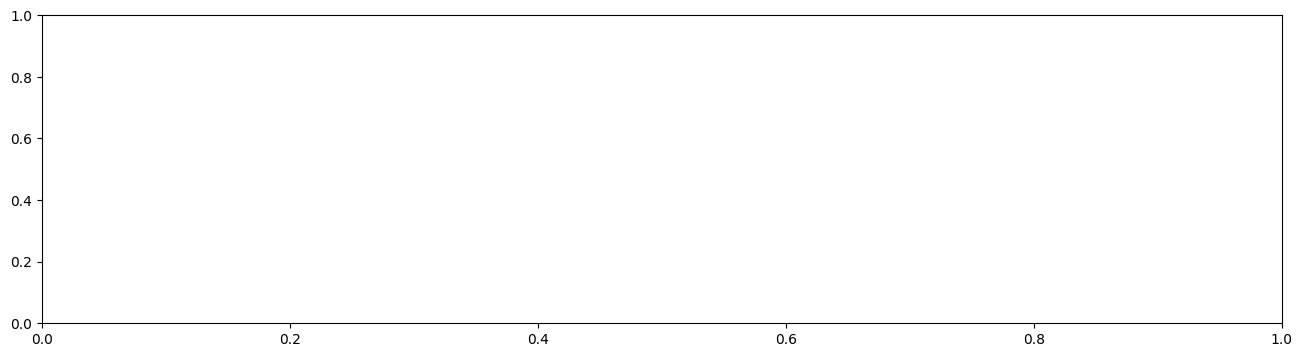

In [36]:
# Plot the results
plt.figure(figsize=(16, 4))
plt.plot(training_sizes, accuracies, marker='o', label="Accuracy")
plt.plot(training_sizes, f1_scores, marker='s', label="F1-Score")
plt.title("Performance vs. Number of Training Subjects")
plt.xlabel("Number of Training Subjects")
plt.ylabel("Performance")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## ------------------------------------------------------Legacy----------------------------------------------------------------


In [19]:
# Process all subjects and combine datasets
data_folder = "data/part_2"
subject_files = [f"{data_folder}/S{i}_A1_E1.mat" for i in range(1, 28)]

# Selecting the features of interest
features_names = ['mav', 'std', 'maxav', 'rms', 'wl', 'ssc', 'var']
features = [mav, std, maxav, rms, wl, ssc, var]

all_datasets = []
all_labels = []
all_subject_ids = []

for subject_id, file_path in enumerate(subject_files, start=1):
    data = loadmat(file_path)
    emg = data["emg"]
    stimulus = data["restimulus"]
    repitition = data["rerepetition"]

    subject_dataset, subject_labels = build_dataset_from_ninapro(emg, stimulus, repitition, features=features)

    print(f"Subject dataset shape: {subject_dataset.shape}")


    # Append to combined dataset
    all_datasets.append(subject_dataset)
    all_labels.append(subject_labels)
    all_subject_ids.extend([subject_id] * len(subject_labels))

# Combine all subjects into unified arrays
X_all = np.vstack(all_datasets)
y_all = np.hstack(all_labels)
subject_ids = np.array(all_subject_ids)

print(f"Combined dataset shape: {X_all.shape}")
print(f"Labels shape: {y_all.shape}")
print(f"Subject IDs shape: {subject_ids.shape}")

Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Subject dataset shape: (120, 70)
Combined dataset shape: (3240, 70)
Labels shape: (3240,)
Subject IDs shape: (3240,)


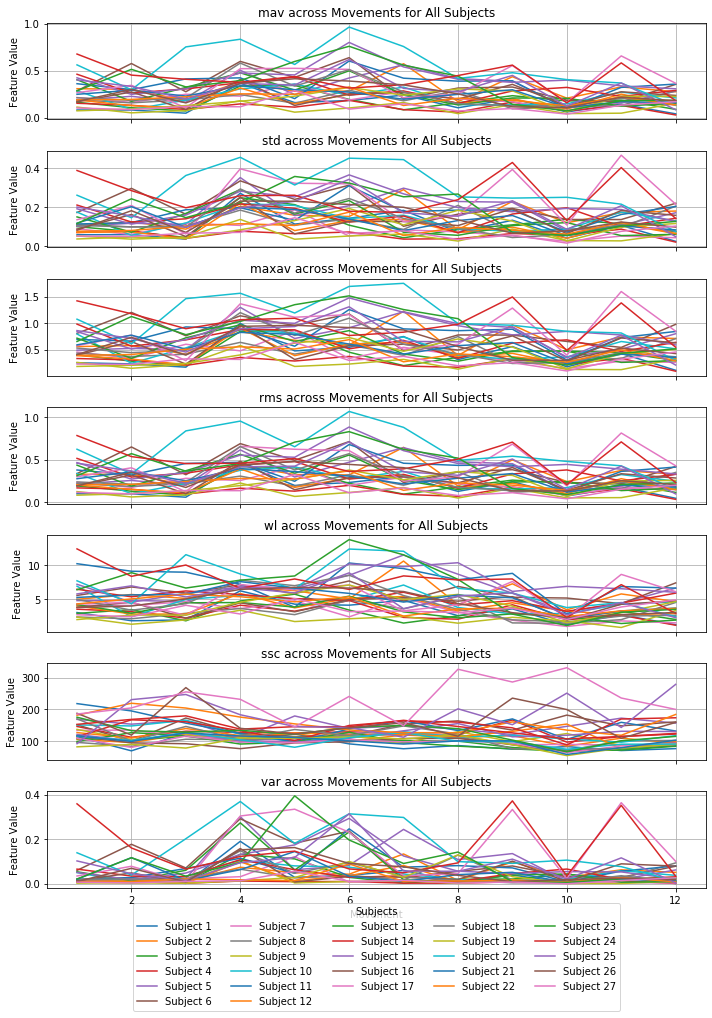

In [25]:
subject_feature_movement = []

for subject_id, file_path in enumerate(subject_files, start=1):
    data = loadmat(file_path)
    emg = data["emg"]
    stimulus = data["restimulus"]
    repetition = data["rerepetition"]

    # Build dataset
    dataset, _ = build_dataset_from_ninapro(emg, stimulus, repetition, features=features)

    # Calculate averages for each stimulus
    # -1 because 0 is the resting condition
    n_stimuli = len(np.unique(stimulus)) - 1 
    # -1 because 0 is not a repetition
    n_repetitions = len(np.unique(repetition)) - 1 
    n_channels = emg.shape[1]
    subject_movement_features = []

    for i in range(len(features)):
        feature_stimuli = np.zeros((n_stimuli, n_channels))  # Average features for each stimulus
        feature_idx = i * n_channels + np.arange(n_channels)
        for j in range(n_stimuli):
            idx_repetitions = np.arange(j * n_repetitions, (j + 1) * n_repetitions)
            feature_stimuli[j, :] = np.mean(dataset[idx_repetitions[:, None], feature_idx], axis=0)
        subject_movement_features.append(feature_stimuli)

    subject_feature_movement.append(subject_movement_features)

# Plot features across subjects and movements
x_axis = np.arange(1, n_stimuli + 1)

fig, axs = plt.subplots(len(features), 1, figsize=(10, 15), sharex=True)

for i, feature_name in enumerate(features_names):
    for subject_id, subject_features in enumerate(subject_feature_movement):
        axs[i].plot(
            x_axis,
            np.mean(subject_features[i], axis=1),  # Average across channels
            label=f"Subject {subject_id + 1}"
        )
    axs[i].set_title(f"{feature_name} across Movements for All Subjects")
    axs[i].set_ylabel("Feature Value")
    axs[i].grid()

axs[-1].set_xlabel("Movement")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=5, title="Subjects")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [22]:
# Splitting into Training (75%) and Testing Set (25%)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.25, stratify = y_all)

# Standardizing data w.r.t to X_train
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test)   
print(f"Shapes =  X_train: {X_train_z.shape} | X_test: {X_test_z.shape}")

Shapes =  X_train: (2430, 70) | X_test: (810, 70)


In [ ]:
def remove_inactive_channels(emg_data, threshold=0.01):
    channel_variances = np.var(emg_data, axis=0)
    inactive_channels = np.where(channel_variances < threshold)[0]
    clean_emg = np.delete(emg_data, inactive_channels, axis=1)
    return clean_emg, inactive_channels

In [ ]:
#Load and proprocess all subjects
all_data = []
all_labels = []
all_subject_ids = []

for subject_id, file in enumerate(subject_files, start=1):
    emg, stimulus, repetition = getSmoothedEmgWindows(file, 25)

    clean_emg, inactive_channels = remove_inactive_channels(emg, 0.005)

    print(f"Inactive channels removed: {inactive_channels}")
    print(f"New EMG shape: {clean_emg.shape}")

#

Inactive channels removed: [3 4 5]
New EMG shape: (101014, 7)
Inactive channels removed: [4 5 6]
New EMG shape: (100686, 7)
Inactive channels removed: [3 4 5]
New EMG shape: (100720, 7)
Inactive channels removed: [3 4 5 9]
New EMG shape: (100835, 6)
Inactive channels removed: [0 4 5]
New EMG shape: (100894, 7)
Inactive channels removed: [0 4]
New EMG shape: (101083, 8)
Inactive channels removed: [0 2 3 4]
New EMG shape: (100817, 6)
Inactive channels removed: [0 4 5]
New EMG shape: (100854, 7)
Inactive channels removed: [0 1 3 4 5 7]
New EMG shape: (100925, 4)
Inactive channels removed: [0 3 4]
New EMG shape: (100778, 7)
Inactive channels removed: [0 4]
New EMG shape: (100899, 8)
Inactive channels removed: [3 4 5 9]
New EMG shape: (100920, 6)
Inactive channels removed: [3 4 9]
New EMG shape: (100948, 7)
Inactive channels removed: [4 5 7]
New EMG shape: (100785, 7)
Inactive channels removed: [3 4]
New EMG shape: (101508, 8)
Inactive channels removed: [3 4 5]
New EMG shape: (101191, 7)
In

In [ ]:
data_folder = "data/part_2"
subject_files = [f"{data_folder}/S{i}_A1_E1.mat" for i in range(1, 28)]

def getSmoothedEmgWindows(file_path, mov_mean_length):
    data = loadmat(file_path)   
    emg_rectified = data["emg"].copy()
    stimulus = data["restimulus"] 
    repetition = data["rerepetition"] 

    # -1 because 0 is the resting condition
    n_stimuli = len(np.unique(stimulus)) - 1 
    # -1 because 0 is not a repetition
    n_repetitions = len(np.unique(repetition)) - 1 
    n_channels = emg_rectified.shape[1]

    # Apply moving average filter (smoothing)
    mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

    #initializing the data structure    
    emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
    emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
            emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
            emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 

    return  emg_rectified, stimulus, repetition


c:\Users\katla\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


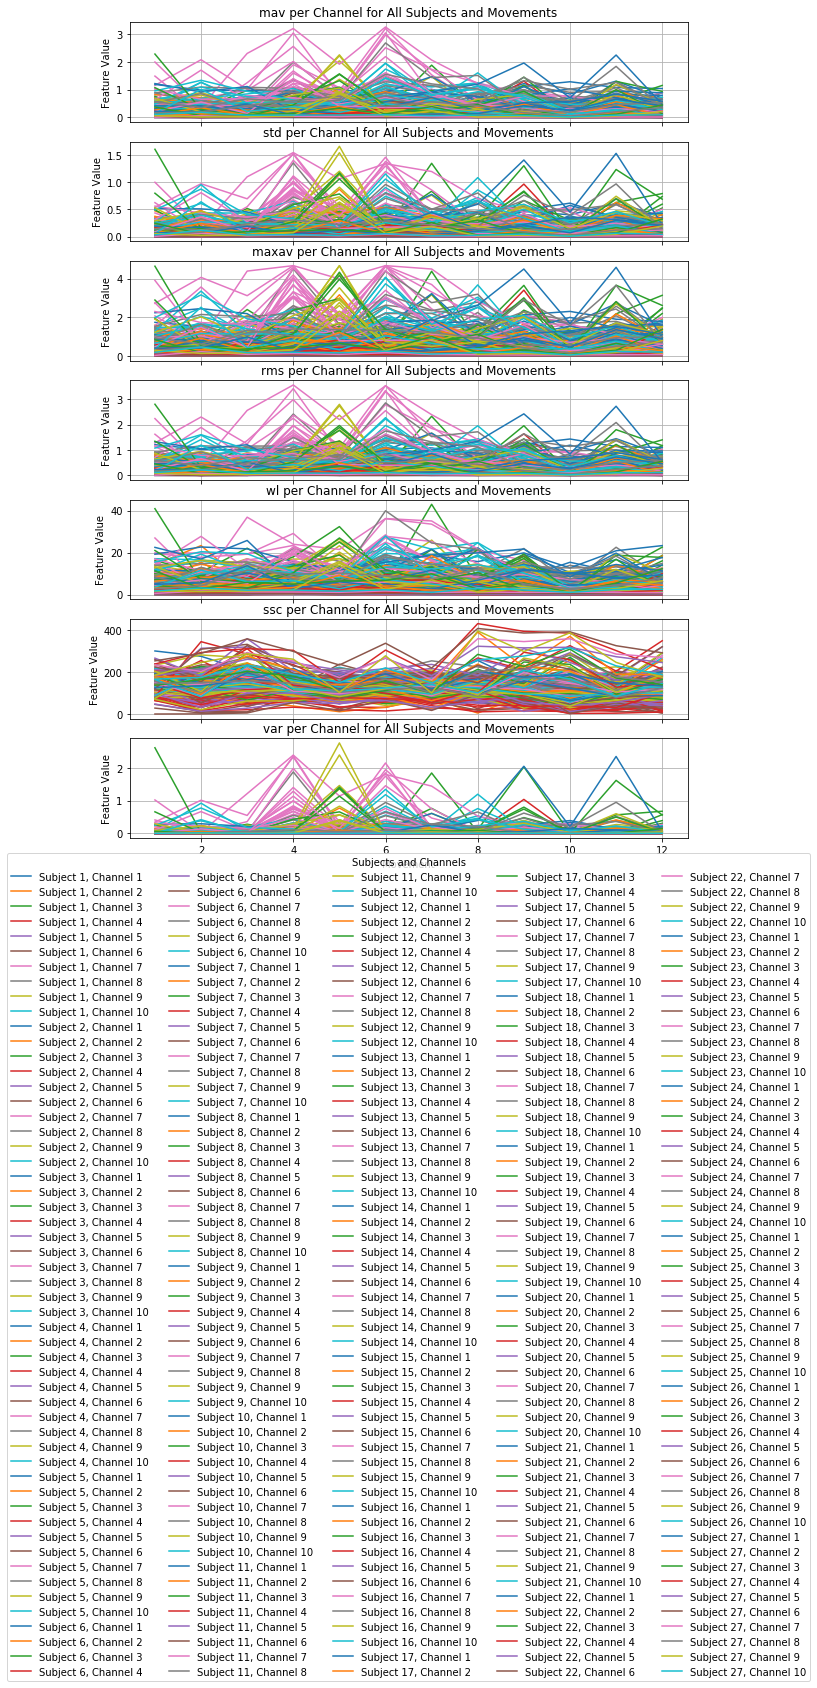

In [ ]:
def plot_avg_per_channel(subject_feature_movement, features_names, n_stimuli, n_channels):
    x_axis = np.arange(1, n_stimuli + 1)

    fig, axs = plt.subplots(len(features_names), 1, figsize=(10, 15), sharex=True)

    for i, feature_name in enumerate(features_names):
        for subject_id, subject_features in enumerate(subject_feature_movement):
            # Extract per-channel averages for the current feature
            for channel in range(n_channels):
                axs[i].plot(
                    x_axis,
                    subject_features[i][:, channel],  # Average per channel
                    label=f"Subject {subject_id + 1}, Channel {channel + 1}"
                )
        axs[i].set_title(f"{feature_name} per Channel for All Subjects and Movements")
        axs[i].set_ylabel("Feature Value")
        axs[i].grid()

    axs[-1].set_xlabel("Movement")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=5, title="Subjects and Channels")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Calculate the number of stimuli and channels from the first subject
n_stimuli = len(np.unique(processed_subjects[0]["stimulus"])) - 1  # -1 to exclude resting condition
n_channels = processed_subjects[0]["dataset"].shape[1] // len(features)  # Channels divided by number of features

# Call the function
plot_avg_per_channel(subject_feature_movement, features_names, n_stimuli, n_channels)